In [1]:
import pandas as pd
import polars as pl
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.width', 150)
pd.set_option('future.no_silent_downcasting', True)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
sns.set()

In [2]:
dates = ['session_start', 'session_end', 'session_date', 'order_dt']
df = pd.read_csv('ecom_go_2.csv', parse_dates=dates)
df_pl = pl.from_pandas(df)

print(df.shape)
print(df.columns.tolist())

(1009, 19)
['user_id', 'region', 'device', 'channel', 'session_start', 'session_end', 'sessiondurationsec', 'session_date', 'month', 'day', 'hour_of_day', 'order_dt', 'revenue', 'payment_type', 'promo_code', 'final_price', 'time_of_day', 'payer', 'week']


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             1009 non-null   int64         
 1   region              1009 non-null   object        
 2   device              1009 non-null   object        
 3   channel             1009 non-null   object        
 4   session_start       1009 non-null   datetime64[ns]
 5   session_end         1009 non-null   datetime64[ns]
 6   sessiondurationsec  1009 non-null   int64         
 7   session_date        1009 non-null   datetime64[ns]
 8   month               1009 non-null   int64         
 9   day                 1009 non-null   int64         
 10  hour_of_day         1009 non-null   int64         
 11  order_dt            282 non-null    datetime64[ns]
 12  revenue             1009 non-null   int64         
 13  payment_type        282 non-null    object      

In [4]:
df_unchanged = df.copy()
print(df_unchanged.shape, df_unchanged['payer'].sum())

df_replaced = df.copy()
df_replaced['revenue'] = np.where(df_replaced['revenue'] == 100000, 9999, df_replaced['revenue'])
df_replaced['revenue'] = np.where(df_replaced['revenue'] == 1, 4999, df_replaced['revenue'])
print(df_replaced.shape, df_replaced['payer'].sum())

df_removed = df.copy()
to_remove = df[df['revenue'].isin([1, 100000])].index
df_removed.drop(to_remove, inplace=True)
print(df_removed.shape, df_removed['payer'].sum())


dfs = [(df_unchanged, "ORIGINAL DATAFRAME:"), 
       (df_replaced, "REPLACED DATAFRAME:"), 
       (df_removed, "REMOVED DATAFRAME:")]

(1009, 19) 282
(1009, 19) 282
(1003, 19) 276


### `Влияет ли тип устройства на количество покупок в день по каждому региону?`

United States 6.495640408149409e-27
France 3.535860432523009e-16
Germany 1.3211037098502413e-15
UK 2.7564709916866203e-15


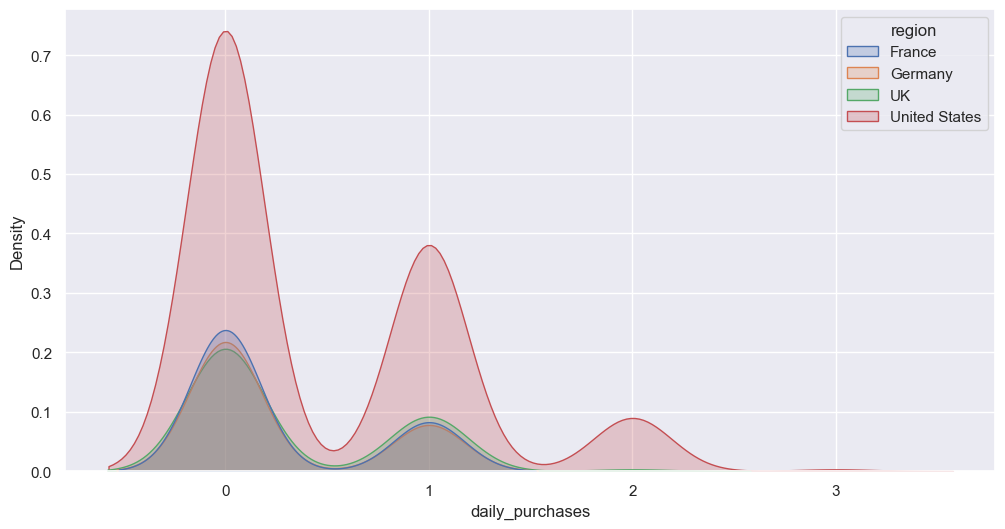

In [81]:
def normality_test(df):
    grouped = df.groupby(['region', 'device', 'session_date'])['payer'].sum().reset_index()
    grouped.rename(columns={'payer': 'daily_purchases'}, inplace=True)
    
    plt.figure(figsize=(12,6))
    sns.kdeplot(grouped, x='daily_purchases', hue='region', fill=True)
    
    for region in df['region'].unique():
        region_data = grouped[grouped['region'] == region]['daily_purchases']
        statistic, p_value = stats.shapiro(region_data)
        print(region, p_value)

normality_test(df)

In [96]:
def test_hypothesis_1(df):
    grouped = df.groupby(['region', 'device', 'session_date'])['payer'].sum().reset_index()
    grouped.rename(columns={'payer': 'daily_purchases'}, inplace=True)

    for region in df['region'].unique():
        region_data = grouped[grouped['region'] == region]

        groups = [group['daily_purchases'].values for name, group in region_data.groupby('device')]
        stat, p = stats.kruskal(*groups)
        print(region, round(p, 6))
        
test_hypothesis_1(df)

# for df_go, df_name in dfs:
#     print(df_name, test_hypothesis_1(df_go))
#     print()

United States 0.330828
France 0.191148
Germany 0.641236
UK 0.758526


### `Влияет ли тип устройства на совершение покупки в определенный день (Да или Нет) в каждом регионе?`

In [95]:
def test_hypothesis_2(df):
    grouped = df.groupby(['region', 'device', 'session_date'])['payer'].sum().reset_index()
    grouped.rename(columns={'payer': 'daily_purchases'}, inplace=True)
    grouped['purchase_made'] = grouped['daily_purchases'].apply(lambda x: 1 if x > 0 else 0)
    
    for region in df['region'].unique():
        region_data = grouped[grouped['region'] == region]
        
        crosstab = pd.crosstab(region_data['device'], region_data['purchase_made'])
        chi2, p, dof, expected = stats.chi2_contingency(crosstab)
        print(region, round(p, 6))
        
test_hypothesis_2(df)

United States 0.378244
France 0.187342
Germany 0.637253
UK 0.792335


### `Влияет ли тип рекламного канала на количество покупок в день по каждому региону?`

United States 3.6089853521507336e-24
France 2.2988170659926374e-15
Germany 3.702049171617313e-15
UK 4.312893156913889e-15


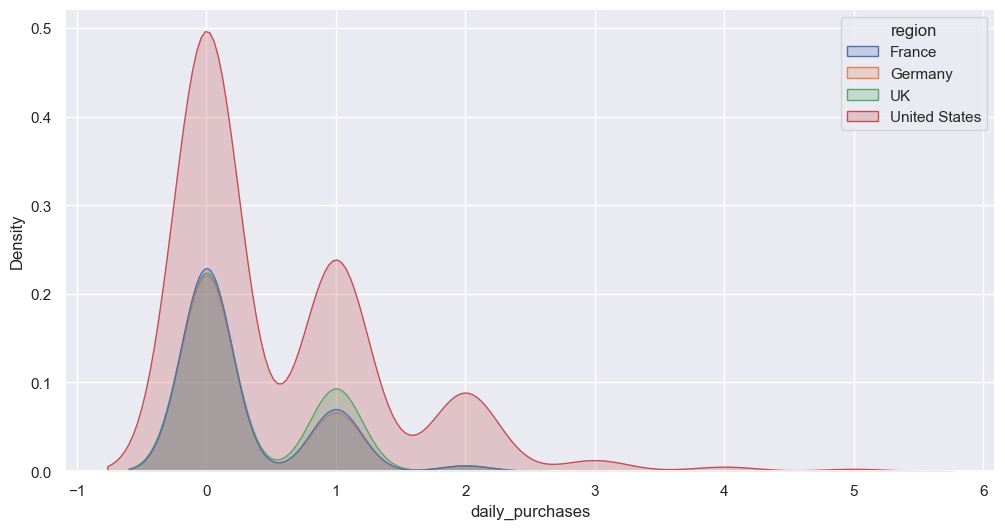

In [98]:
def normality_test(df):
    grouped = df.groupby(['region', 'channel', 'session_date'])['payer'].sum().reset_index()
    grouped.rename(columns={'payer': 'daily_purchases'}, inplace=True)
    
    plt.figure(figsize=(12,6))
    sns.kdeplot(grouped, x='daily_purchases', hue='region', fill=True)
    
    for region in df['region'].unique():
        region_data = grouped[grouped['region'] == region]['daily_purchases']
        statistic, p_value = stats.shapiro(region_data)
        print(region, p_value)

normality_test(df)

In [104]:
def test_hypothesis_3(df):
    grouped = df.groupby(['region', 'channel', 'session_date'])['payer'].sum().reset_index()
    grouped.rename(columns={'payer': 'daily_purchases'}, inplace=True)

    for region in df['region'].unique():
        region_data = grouped[grouped['region'] == region]

        groups = [group['daily_purchases'].values for name, group in region_data.groupby('channel')]
        stat, p = stats.kruskal(*groups)
        print(region, round(p, 6))
        
test_hypothesis_3(df)

# for df_go, df_name in dfs:
#     print(df_name, test_hypothesis_3(df_go))
#     print()

United States 0.025528
France 0.12642
Germany 0.951457
UK 0.774942


### `Проверить гипотезу о том, что средний чек отличается в зависимости от региона?`

In [116]:
def normality_test_aov(df):

#     region_aov = df.groupby('region').apply(
#         lambda group: ((group['revenue'].sum() / group[group['payer'] == 1]['user_id']
#                         .nunique()).round().astype(int))
#     ).reset_index()
#     region_aov.columns = ['region', 'AOV']
    
    region_aov = df.groupby('region').agg(
        AOV=('revenue', lambda x: (x.sum() / x[df['payer'] == 1].nunique()).round().astype(int))
    ).reset_index()

    return region_aov

# Test the function
normality_test_aov(df)


,region,AOV
0,France,109659
1,Germany,45658
2,UK,71242
3,United States,236962


In [109]:
def calculate_average_revenue(df):
    total_revenue = df['revenue'].sum()

    total_users = df['user_id'].nunique()
    total_paid_users = df[df['revenue'] > 0]['user_id'].nunique()
    
    AOV = (total_revenue / total_paid_users).round().astype(int).item()  # AOV
    ARPU = (total_revenue / total_users).round().astype(int).item()  # ARPU

    return f'{AOV=:,.0f}, {ARPU=:,.0f}'

calculate_average_revenue(df[df['region'] == 'France'])

'AOV=13,159, ARPU=3,194'

In [97]:
grouped = df.groupby(['region', 'device', 'session_date'])['payer'].sum().reset_index()
grouped.rename(columns={'payer': 'daily_purchases'}, inplace=True)

for region in df['region'].unique():
    region_data = grouped[grouped['region'] == region]['daily_purchases']
    
    print(region, region_data.value_counts(dropna=False))

United States daily_purchases
0    257
1    132
2     31
3      1
Name: count, dtype: int64
France daily_purchases
0    75
1    26
Name: count, dtype: int64
Germany daily_purchases
0    70
1    25
Name: count, dtype: int64
UK daily_purchases
0    72
1    32
2     1
Name: count, dtype: int64
